In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv("blueprinty.csv")

In [6]:
df.head()

,patents,region,age,iscustomer
0,0,Midwest,32.5,0
1,3,Southwest,37.5,0
2,4,Northwest,27.0,1
3,3,Northeast,24.5,0
4,3,Southwest,37.0,0


In [7]:
# ### Data

# _todo: Read in data._

# _todo: Compare histograms and means of number of patents by customer status. What do you observe?_

# Blueprinty customers are not selected at random. It may be important to account for systematic differences in the age and regional location of customers vs non-customers.

# _todo: Compare regions and ages by customer status. What do you observe?_

<Axes: >

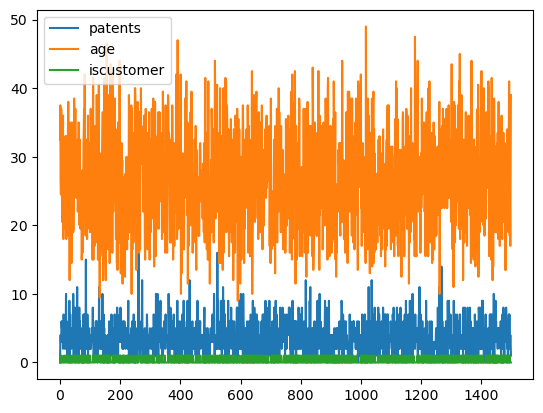

In [8]:
df.plot()

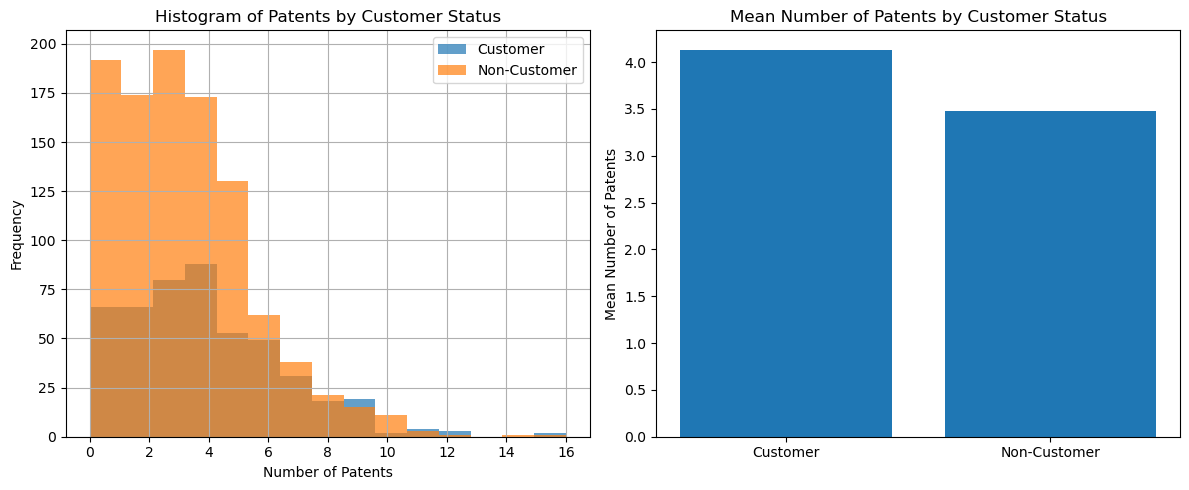

In [9]:
meanp = df["patents"].mean()
meana = df["age"].mean()
meanc = df["iscustomer"].mean()


fig, ax = plt.subplots(1, 2, figsize=(12, 5))

df[df['iscustomer'] == 1]['patents'].hist(ax=ax[0], bins=15, alpha=0.7, label='Customer')
df[df['iscustomer'] == 0]['patents'].hist(ax=ax[0], bins=15, alpha=0.7, label='Non-Customer')
ax[0].set_title('Histogram of Patents by Customer Status')
ax[0].set_xlabel('Number of Patents')
ax[0].set_ylabel('Frequency')
ax[0].legend()

ax[1].bar(['Customer', 'Non-Customer'], [df[df['iscustomer'] == 1]['patents'].mean(), df[df['iscustomer'] == 0]['patents'].mean()])
ax[1].set_title('Mean Number of Patents by Customer Status')
ax[1].set_ylabel('Mean Number of Patents')

plt.tight_layout()
plt.show()

## The mean difference suggests Blueprinty customers have more patents.

Customers average ~4.1 patents, non-customers average ~3.4 patents.

That's a ~20% increase on average.


But again, this is a correlation, not a causal claim maybe older or more experienced firms are more likely to buy the software and have more patents.

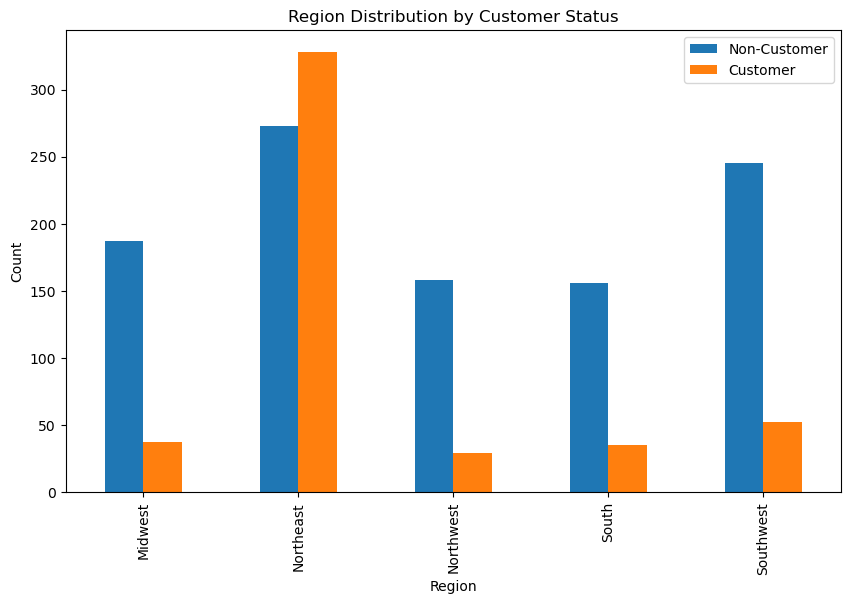

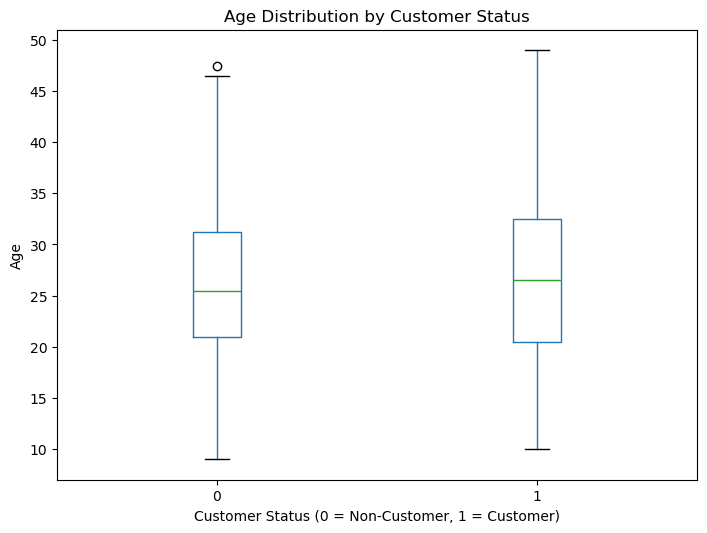

In [10]:

region_counts = df.groupby(['region', 'iscustomer']).size().unstack()
region_counts.plot(kind='bar', stacked=False, figsize=(10, 6))
plt.title('Region Distribution by Customer Status')
plt.xlabel('Region')
plt.ylabel('Count')
plt.legend(['Non-Customer', 'Customer'])
plt.show()

df.boxplot(column='age', by='iscustomer', grid=False, figsize=(8, 6))
plt.title('Age Distribution by Customer Status')
plt.suptitle('')  # Remove the default title
plt.xlabel('Customer Status (0 = Non-Customer, 1 = Customer)')
plt.ylabel('Age')
plt.show()

In [11]:
import numpy as np
import statsmodels.api as sm
import patsy

The likelihood function is:

L(λ; Y₁, Y₂, ..., Yₙ) = Π f(Yᵢ | λ)

Using the Poisson PMF f(Y | λ) = (e^(-λ) * λ^Y) / Y!, the likelihood becomes:

L(λ; Y₁, Y₂, ..., Yₙ) = Π [(e^(-λ) * λ^(Yᵢ)) / Yᵢ!]

Simplify:

L(λ; Y₁, Y₂, ..., Yₙ) = e^(-nλ) * λ^(ΣYᵢ) * Π (1 / Yᵢ!)


In [12]:
df['age_squared'] = df['age'] ** 2

In [13]:

y, X = patsy.dmatrices('patents ~ age + age_squared + C(region) + iscustomer', data=df, return_type='dataframe')

In [14]:
poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                patents   No. Observations:                 1500
Model:                            GLM   Df Residuals:                     1492
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3258.1
Date:                Wed, 07 May 2025   Deviance:                       2143.3
Time:                        19:11:22   Pearson chi2:                 2.07e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1360
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.5089      0.183     -2.778      0.005      -0.868      -0.150
C(region)[T.Northeast]     0.0292      0.044      0.669      0.504      -0.056       0.115
C(region)[T.Northwest]    -0.0176      0.054     -0.327      0.744      -0.123       0.088
C(region)[T.South]         0.0566      0.053      1.074      0.283      -0.047       0.160
C(region)[T.Southwest]     0.0506      0.047      1.072      0.284      -0.042       0.143
age                        0.1486      0.014     10.716      0.000       0.121       0.176
age_squared               -0.0030      0.000    -11.513      0.000      -0.003      -0.002
iscustomer                 0.2076      0.031      6.719      0.000       0.147       0.268
==========================================================================================
"""

/tmp/ipykernel_42900/1539191573.py:6: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.prod(np.exp(-lambda_) * lambda_**Y / np.vectorize(np.math.factorial)(Y))
/tmp/ipykernel_42900/1539191573.py:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(Y * np.log(lambda_) - lambda_ - np.log(np.vectorize(np.math.factorial)(Y)))


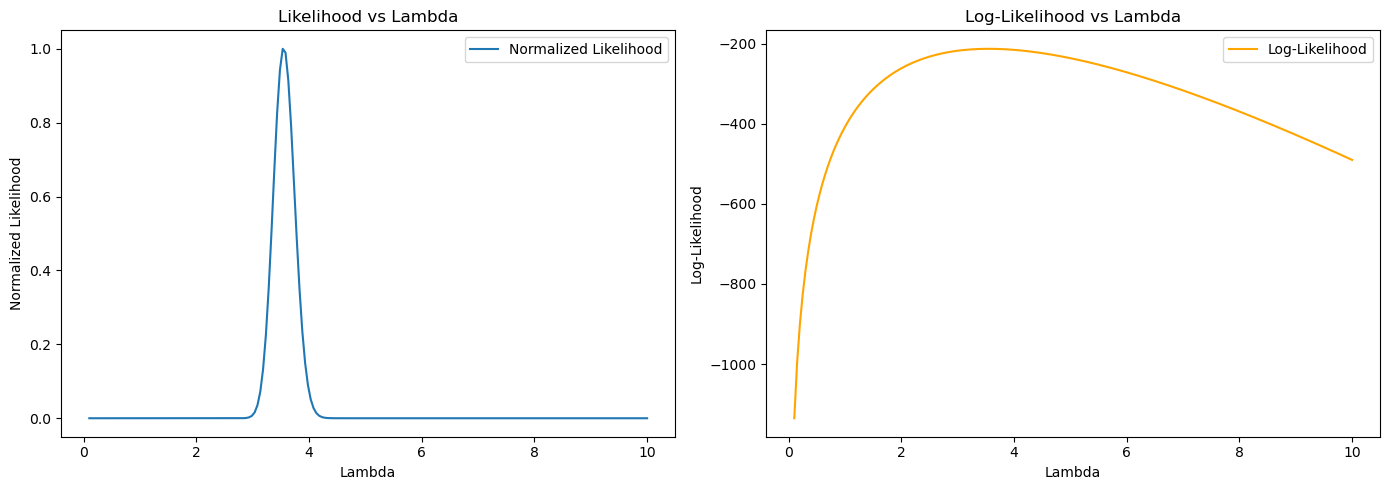

In [15]:
Y = df['patents'].sample(100, random_state=1).values

lambda_vals = np.linspace(0.1, 10, 200)

def poisson_likelihood(lambda_, Y):
    return np.prod(np.exp(-lambda_) * lambda_**Y / np.vectorize(np.math.factorial)(Y))

def poisson_log_likelihood(lambda_, Y):
    return np.sum(Y * np.log(lambda_) - lambda_ - np.log(np.vectorize(np.math.factorial)(Y)))

likelihoods = [poisson_likelihood(lam, Y) for lam in lambda_vals]
log_likelihoods = [poisson_log_likelihood(lam, Y) for lam in lambda_vals]

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
likelihoods_normalized = likelihoods / np.max(likelihoods)
ax[0].plot(lambda_vals, likelihoods_normalized, label='Normalized Likelihood')
ax[0].set_title('Likelihood vs Lambda')
ax[0].set_xlabel('Lambda')
ax[0].set_ylabel('Normalized Likelihood')
ax[0].legend()

ax[1].plot(lambda_vals, log_likelihoods, color='orange', label='Log-Likelihood')
ax[1].set_title('Log-Likelihood vs Lambda')
ax[1].set_xlabel('Lambda')
ax[1].set_ylabel('Log-Likelihood')
ax[1].legend()

plt.tight_layout()
plt.show()

In [16]:
from scipy.optimize import minimize

def negative_log_likelihood(lambda_, Y):
    return -np.sum(Y * np.log(lambda_) - lambda_ - np.log(np.vectorize(np.math.factorial)(Y)))

initial_guess = [1.0]

result = minimize(negative_log_likelihood, initial_guess, args=(Y,), bounds=[(0.001, None)])
mle_lambda = result.x[0]
print(f"MLE for lambda: {mle_lambda}")

MLE for lambda: 3.55000003515202


/tmp/ipykernel_42900/2171826159.py:4: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return -np.sum(Y * np.log(lambda_) - lambda_ - np.log(np.vectorize(np.math.factorial)(Y)))


In [17]:

subset_df = df.sample(500, random_state=42).copy()

subset_df['age_squared'] = subset_df['age'] ** 2
subset_df['intercept'] = 1
subset_df['region_NE'] = (subset_df['region'] == 'Northeast').astype(int)
subset_df['region_NW'] = (subset_df['region'] == 'Northwest').astype(int)
subset_df['region_S']  = (subset_df['region'] == 'South').astype(int)
subset_df['region_SW'] = (subset_df['region'] == 'Southwest').astype(int)

X = subset_df[['intercept', 'age', 'age_squared', 'iscustomer', 'region_NE', 'region_NW', 'region_S', 'region_SW']].values
Y = subset_df['patents'].values

def poisson_regression_log_likelihood(beta, Y, X):
    lambda_ = np.exp(X @ beta)  # lambda_i = exp(X_i' * beta)
    return -np.sum(Y * np.log(lambda_) - lambda_ - np.log(np.vectorize(np.math.factorial)(Y)))

beta_init = np.zeros(X.shape[1])
a
result = minimize(poisson_regression_log_likelihood, x0=beta_init, args=(Y, X), method='BFGS')

beta_mle = result.x
beta_mle


NameError: name 'a' is not defined

In [ ]:
from scipy.optimize import minimize
from numpy.linalg import inv
import statsmodels.api as sm
subset_df['age_centered'] = subset_df['age'] - subset_df['age'].mean()
subset_df['age_squared_centered'] = subset_df['age_centered'] ** 2

X_stable = subset_df[['intercept', 'age_centered', 'age_squared_centered', 'iscustomer', 'region_NE', 'region_NW', 'region_S', 'region_SW']].values
Y = subset_df['patents'].values

def poisson_regression_log_likelihood(beta, Y, X):
    lambda_ = np.exp(X @ beta)
    return -np.sum(Y * np.log(lambda_) - lambda_ - np.log(np.vectorize(np.math.factorial)(Y)))

beta_init = np.zeros(X_stable.shape[1])

result = minimize(poisson_regression_log_likelihood, x0=beta_init, args=(Y, X_stable), method='BFGS')

beta_hat = result.x
hessian_inv = result.hess_inv  # Inverse of Hessian for standard errors

standard_errors = np.sqrt(np.diag(hessian_inv))

coef_names = ['Intercept', 'Age (centered)', 'Age^2 (centered)', 'IsCustomer', 'Region_NE', 'Region_NW', 'Region_S', 'Region_SW']
coef_table = pd.DataFrame({
    'Coefficient': beta_hat,
    'Std_Error': standard_errors
}, index=coef_names)


X_sm = sm.add_constant(subset_df[['age_centered', 'age_squared_centered', 'iscustomer', 'region_NE', 'region_NW', 'region_S', 'region_SW']])
glm_model = sm.GLM(Y, X_sm, family=sm.families.Poisson()).fit()

glm_model.summary()


/tmp/ipykernel_71231/573373535.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return -np.sum(Y * np.log(lambda_) - lambda_ - np.log(np.vectorize(np.math.factorial)(Y)))


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  500
Model:                            GLM   Df Residuals:                      492
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1118.6
Date:                Wed, 07 May 2025   Deviance:                       783.71
Time:                        18:42:50   Pearson chi2:                     764.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1181
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.3880      0.064     21.539      0.000       1.262       1.514
age_centered            -0.0035      0.004     -0.956      0.339      -0.011       0.004
age_squared_centered    -0.0028      0.000     -6.263      0.000      -0.004      -0.002
iscustomer               0.2421      0.052      4.634      0.000       0.140       0.345
region_NE               -0.0829      0.074     -1.118      0.263      -0.228       0.062
region_NW                0.0225      0.092      0.245      0.806      -0.157       0.202
region_S                 0.0426      0.088      0.484      0.628      -0.130       0.215
region_SW                0.0215      0.078      0.275      0.783      -0.132       0.175
========================================================================================
"""

In [3]:

airbnb_df = pd.read_csv("airbnb.csv")
airbnb_df.info(), airbnb_df.isnull().sum()
airbnb_df.head()


NameError: name 'pd' is not defined

In [67]:
airbnb_clean = airbnb_df.dropna(subset=[
    'bathrooms', 'bedrooms', 'review_scores_cleanliness',
    'review_scores_location', 'review_scores_value'
])

airbnb_clean['instant_bookable'] = (airbnb_clean['instant_bookable'] == 't').astype(int)

room_dummies = pd.get_dummies(airbnb_clean['room_type'], prefix='room', drop_first=True)

X_airbnb = pd.concat([
    airbnb_clean[['days', 'bathrooms', 'bedrooms', 'price', 
                  'review_scores_cleanliness', 'review_scores_location', 
                  'review_scores_value', 'instant_bookable']],
    room_dummies
], axis=1)

Y_airbnb = airbnb_clean['number_of_reviews']

X_airbnb = sm.add_constant(X_airbnb)



/tmp/ipykernel_71231/2129499680.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airbnb_clean['instant_bookable'] = (airbnb_clean['instant_bookable'] == 't').astype(int)


In [68]:

X_airbnb.dtypes


const                        float64
days                           int64
bathrooms                    float64
bedrooms                     float64
price                          int64
review_scores_cleanliness    float64
review_scores_location       float64
review_scores_value          float64
instant_bookable               int64
room_Private room               bool
room_Shared room                bool
dtype: object

In [ ]:

X_airbnb = X_airbnb.astype(float)

airbnb_model = sm.GLM(Y_airbnb, X_airbnb, family=sm.families.Poisson()).fit()

airbnb_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      number_of_reviews   No. Observations:                30160
Model:                            GLM   Df Residuals:                    30149
Model Family:                 Poisson   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -5.2418e+05
Date:                Wed, 07 May 2025   Deviance:                   9.2689e+05
Time:                        18:43:14   Pearson chi2:                 1.37e+06
No. Iterations:                    10   Pseudo R-squ. (CS):             0.6840
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         3.4980      0.016    217.396      0.000       3.467       3.530
days                       5.072e-05   3.91e-07    129.755      0.000       5e-05    5.15e-05
bathrooms                    -0.1177      0.004    -31.394      0.000      -0.125      -0.110
bedrooms                      0.0741      0.002     37.197      0.000       0.070       0.078
price                     -1.791e-05   8.33e-06     -2.151      0.031   -3.42e-05   -1.59e-06
review_scores_cleanliness     0.1131      0.001     75.611      0.000       0.110       0.116
review_scores_location       -0.0769      0.002    -47.796      0.000      -0.080      -0.074
review_scores_value          -0.0911      0.002    -50.490      0.000      -0.095      -0.088
instant_bookable              0.3459      0.003    119.666      0.000       0.340       0.352
room_Private room            -0.0105      0.003     -3.847      0.000      -0.016      -0.005
room_Shared room             -0.2463      0.009    -28.578      0.000      -0.263      -0.229
=============================================================================================
"""

In [1]:
pip install pypandoc


Note: you may need to restart the kernel to use updated packages.


In [18]:
import pypandoc

def convert_docx_to_html(docx_path, output_html_path):
    output = pypandoc.convert_file(
        docx_path, 'html',
        outputfile=output_html_path,
        extra_args=['--standalone', '--toc']
    )
    print(f"HTML saved to: {output_html_path}")

# Example usage
convert_docx_to_html("report2 .docx", "report2.html")


[WARNING] This document format requires a nonempty <title> element.
  Defaulting to 'report2 ' as the title.
  To specify a title, use 'title' in metadata or --metadata title="...".



HTML saved to: report2.html
